In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [0]:
text = 'The reservation was canceled 8 days before arrival. This is an automated posting. It was a wonderful first experience of AirBnB! It was a luck to meet a so welcoming person ;) She did everything to make us feel like in our home. She shared with us her advices and her good plans about the city... But also her friends and delicious egyptian cook! What beautiful meetings... Just perfect. Staying with Basma was an incredibly pleasant experience, and I wouldnt hesitate to stay in her home next time Im in Istanbul. The room I stayed it was very comfortable and spacious, she was constantly offering me snacks and tea, and provided maps and helpful suggestions for planning my day in Istanbul. Highly Recommended! '

In [0]:
wordcloud = WordCloud().generate(text)

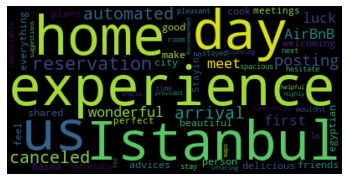

In [16]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()